In [1]:
import json
import h5py

import numpy as np

In [2]:
PATH_TO_DATA = '../data/prepro/'

***

## Load data

In [3]:
data = json.load(open(PATH_TO_DATA + 'data_prepro.json', 'r'))

idx2word = dict(data['ix_to_word'])
idx2word = dict([(int(key), word) for key, word in idx2word.items()])

idx2ans = dict(data['ix_to_ans'])
idx2ans = dict([(int(key), word) for key, word in idx2ans.items()])

image_train = data['unique_img_train']
image_test = data['unique_img_test']

In [8]:
dataset = h5py.File(PATH_TO_DATA + 'data_prepro.h5')

print(f'Dataset columns:\n {list(dataset.keys())}')

Dataset columns:
 ['MC_ans_test', 'answers', 'img_pos_test', 'img_pos_train', 'ques_length_test', 'ques_length_train', 'ques_test', 'ques_train', 'question_id_test', 'question_id_train']


In [24]:
answers_train = np.array(dataset['answers'])

ques_train = np.array(dataset['ques_train'])
ques_test = np.array(dataset['ques_test'])

img_pos_train = np.array(dataset['img_pos_train'])
img_pos_test = np.array(dataset['img_pos_test'])

***

## Data Generator

In [24]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [25]:
def load_image(filename, target_size=(299, 299)) :
    img = Image.open(filename)
    img.load()
    img = img.resize(target_size)
    return np.asarray(img, dtype='int32')

Image shape: (299, 299, 3)


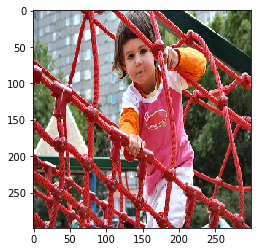

In [26]:
img = load_image(IMAGES_DIR+'1007320043_627395c3d8.jpg')
print(f'Image shape: {img.shape}')

plt.imshow(img);

In [27]:
# data generator, intended to be used in a call to model.fit_generator()

def data_generator(image_descriptions_set, img_names_set, word2idx, max_length, num_images_per_batch):
    X_img = np.zeros((num_images_per_batch*5, 299, 299, 3))
    X_seq = []
    Y_seq = []
    n = 0
    
    # loop for ever over images
    while True:
        for img_name, desc_list in image_descriptions_set.items():
            n+=1

            # retrieve the photo feature
            img = load_image(IMAGES_DIR + img_name + '.jpg')

            for desc in desc_list:
                X_img[n] = img
                
                # encode the sequence
                y_seq = [word2idx[word] for word in desc.split() if word in word2idx]
                x_seq = [word2idx['0']] + y_seq[:-1]
                
                Y_seq.append(y_seq)
                X_seq.append(x_seq)

            # yield the batch data
            if n == num_images_per_batch:
                X_seq = pad_sequences(X_seq, maxlen=max_length, padding='post')
                Y_seq = pad_sequences(Y_seq, maxlen=max_length, padding='post')
                
                # One-hot
                Y_seq = [[to_categorical(idx, len(vocabulary)) for idx in sent] for sent in Y_seq]
                
                yield [[X_img, X_seq], np.array(Y_seq)]

                X_img = np.zeros((num_images_per_batch*5, 299, 299, 3))
                X_seq = []
                Y_seq = []
                n = 0

***

In [28]:
from keras import Model
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Input, Embedding, Dropout, LSTM, Dense, Activation, Reshape
from keras.optimizers import Adam
from keras.utils import plot_model



# Image Encoder (ConvNet)

We are making use of the **Transfer Learning** technique.<br>
We are using the CNN Inception V3 trained on ImageNet by Google Brain team on Cloud TPUs.
<br><br>

Here is the network architecture:
![InceptionV3](../img/InceptionV3.png)

In [29]:
IMG_VECTOR_DIM = 256

In [30]:
img_in = Input((299, 299, 3), name='image_input')
    
# Get the InceptionV3 model trained on imagenet data
inceptionv3 = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
inceptionv3 = Model(inceptionv3.input, inceptionv3.layers[-2].output, name='inceptionv3')

# Do not alter the weights of the InceptionV3 model
for layer in inceptionv3.layers:
    layer.trainable = False
    
x = inceptionv3(img_in)
x = Dropout(0.5, name='dropout_encoder')(x)
x = Dense(IMG_VECTOR_DIM, name='dense_encoder')(x)
x = Activation('relu', name='relu_encoder')(x)
    
image_encoder = Model(img_in, x, name='image_encoder')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [31]:
plot_model(image_encoder, to_file='image_encoder.png', show_shapes=True, show_layer_names=True)

print(image_encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 299, 299, 3)       0         
_________________________________________________________________
inceptionv3 (Model)          (None, 2048)              21802784  
_________________________________________________________________
dropout_encoder (Dropout)    (None, 2048)              0         
_________________________________________________________________
dense_encoder (Dense)        (None, 256)               524544    
_________________________________________________________________
relu_encoder (Activation)    (None, 256)               0         
Total params: 22,327,328
Trainable params: 524,544
Non-trainable params: 21,802,784
_________________________________________________________________
None


***

# Sequence Decoder (LSTM)
<br>
A LSTM network

![LSTM_net](../img/LSTM.png)

### Word Embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/))

In [32]:
GLOVE_300_DIR = PATH_TO_DATA + 'glove.6B/glove.6B.300d.txt'

def load_word_embedding_map(path_to_embeddings):
    word_embedding = dict()

    with open(GLOVE_300_DIR, encoding='utf-8') as f_embeddings:
        for line in f_embeddings:
            values = line.split()
            word_embedding[values[0]] = np.asarray(values[1:], dtype='float64')
    
    return word_embedding


# Load the Word Embeddings
word_embedding = load_word_embedding_map(GLOVE_300_DIR)

In [33]:
def cosine_similarity(v, w):
    return np.dot(v, w) / (np.linalg.norm(v) * np.linalg.norm(w))

In [34]:
cosine_similarity(
    word_embedding['man'] - word_embedding['woman'],
    word_embedding['king'] - word_embedding['queen']
)

0.40070248182725027

#### Init the embedding matrix

In [35]:
def init_embedding_matrix(dim):
    embedding_matrix = np.zeros((len(vocabulary), dim))

    for word, idx in word2idx.items():
        try:
            embedding_matrix[idx, :] = word_embedding[word]
        except KeyError:
            pass
        
    return embedding_matrix

embedding_matrix = init_embedding_matrix(300)
print(f'Embedding Matrix shape: {embedding_matrix.shape}')

Embedding Matrix shape: (8765, 300)


## Build the Sequence Decoder

In [36]:
# Sequence Input
seq_in = Input((max_description_length,), name='sequence_input')
encoder_vector_input = Input((IMG_VECTOR_DIM,), name='encoder_vector_input')

# GloVe embeddings
glove_embeddings = Embedding(
    len(vocabulary),
    300,
    input_length=max_description_length,
    mask_zero=True,
    name='glove_embeddings'
)
x = glove_embeddings(seq_in)
    
# Dropout
x = Dropout(0.5, name='dropout')(x)
    
# Sequence Decoder
sequence_decoder = LSTM(IMG_VECTOR_DIM, return_sequences=True, name='sequence_decoder')
x = sequence_decoder(x, initial_state=[encoder_vector_input, encoder_vector_input])
    
# Dense -> Softmax
x = Dense(len(vocabulary), name='dense_decoder')(x)
x = Activation('softmax', name='softmax_decoder')(x)
    
sequence_decoder = Model(inputs=[seq_in, encoder_vector_input], outputs=x, name='sequence_decoder')
# Set GloVe weights
sequence_decoder.get_layer('glove_embeddings').set_weights([embedding_matrix])
sequence_decoder.get_layer('glove_embeddings').trainable = False


In [37]:
plot_model(sequence_decoder, to_file='sequence_decoder.png', show_shapes=True, show_layer_names=True)

print(image_encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 299, 299, 3)       0         
_________________________________________________________________
inceptionv3 (Model)          (None, 2048)              21802784  
_________________________________________________________________
dropout_encoder (Dropout)    (None, 2048)              0         
_________________________________________________________________
dense_encoder (Dense)        (None, 256)               524544    
_________________________________________________________________
relu_encoder (Activation)    (None, 256)               0         
Total params: 22,327,328
Trainable params: 524,544
Non-trainable params: 21,802,784
_________________________________________________________________
None


***

# Model

![NIC_model](../img/NIC.png)

In [38]:
encoder_vector = image_encoder(img_in)
seq_out = sequence_decoder([seq_in, encoder_vector])

# Build the model
model = Model(inputs=[img_in, seq_in], outputs=seq_out, name='NIC')


### Visualize the model

In [39]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 35)           0                                            
__________________________________________________________________________________________________
image_encoder (Model)           (None, 256)          22327328    image_input[0][0]                
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 35, 8765)     5452473     sequence_input[0][0]             
                                                                 image_encoder[1][0]              
Total para

## Training

In [40]:
model.compile(Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.fit_generator(
    data_generator(train_image_descriptions, train_images, word2idx, max_description_length, 32),
    steps_per_epoch=10,
    epochs=100,
    verbose=True,
    callbacks=[ReduceLROnPlateau()]
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
10/10 [==============================] - 161s 16s/step - loss: 9.0657 - acc: 0.0033


/Users/victor/.local/share/virtualenvs/VoiceCV-7axod348/lib/python3.7/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/100
10/10 [==============================] - 154s 15s/step - loss: 9.0069 - acc: 0.0778
Epoch 3/100
10/10 [==============================] - 156s 16s/step - loss: 8.8741 - acc: 0.1018
Epoch 4/100
10/10 [==============================] - 158s 16s/step - loss: 8.5952 - acc: 0.0947
Epoch 5/100
10/10 [==============================] - 157s 16s/step - loss: 8.1499 - acc: 0.0985
Epoch 6/100
 5/10 [==============>...............] - ETA: 1:19 - loss: 7.7984 - acc: 0.0955

KeyboardInterrupt: 

***

# Inference

![LSTM_sampling](../img/Sampling.png)

In [42]:
img_id = '1000268201_693b08cb0e'

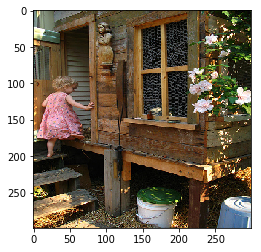

In [43]:
img = load_image(IMAGES_DIR+img_id+'.jpg')
plt.imshow(img);

In [44]:
train_image_descriptions[img_id]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

In [45]:
img.shape

(299, 299, 3)

In [46]:
def inference(image):
    encoder_vector = image_encoder.predict(np.array([image]))[0]
    target_seq = np.zeros((1, max_description_length))

    stop_condition = False
    decoded_sentence = ''
    k = 0
    while not stop_condition:
        output_tokens = sequence_decoder.predict([target_seq, np.array([encoder_vector])])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, k, :])
        sampled_word = idx2word[sampled_token_index]
        decoded_sentence += sampled_word + ' '

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '0' or
           len(decoded_sentence) > max_description_length):
            stop_condition = True

        target_seq[0, k] = sampled_token_index
        k+=1

    return decoded_sentence[:-1]

In [47]:
# 'subdivsion magnificant affectionately '

inference(img)

'a a a a a a a a a a a a a a a a a a'